In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
#import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [2]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [3]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [4]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth

    def fit(self, X, y=None):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        
        # Your code goes here
             
        if self.depth >= self.max_depth:
            splitting = False
            #print('not splitting because too deep' + ' max depth is ' + str(self.max_depth))
            
        elif len(X) < self.min_sample:
            splitting = False
            #print('not splitting because too little samples')
        
        else:
            splitting = True
            #print('splitting' + ' max depth = ' + str(self.max_depth))
            
        if splitting == False:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        else:
            self.is_leaf = False
            #Initialise lists
            feature_loss = []
            feature_split = []
            
            n,m = X.shape
            
            for j in range(m):
                #list all the unique values in X.j and sort them by ascending order
                unique = list(np.unique(X[:,j]))
                unique.sort()
                
                #create a list of splitting points
                s_list = [] #modify to array later if you can
                loss_list = []
                
                for i in range(len(unique)-1):
                    s = 0.5 *(unique[i] + unique[i+1])
                    
                    #split the data 
                    left_mask = (X[:,j] <= s)
                    right_mask = (X[:,j] > s)
                    
                    left_split_X = X[left_mask,:]
                    right_split_X = X[right_mask,:]
                    
                    left_split_y = y[left_mask]
                    right_split_y = y[right_mask]
                    
                    #calculate the estimate for each split
                    left_estimate = self.leaf_value_estimator(left_split_y)
                    right_estimate = self.leaf_value_estimator(right_split_y)
                    
                    #calculate the loss for the split
                    NL = len(left_split_X)
                    NR = len(right_split_X)
                    loss = NL*self.split_loss_function(left_split_y) + NR*self.split_loss_function(right_split_y)
                    
                    loss_list.append(loss)
                    s_list.append(s)
                
                #Find the value of the split that minimizes the loss
                min_loss, idx = min((val, idx) for (idx, val) in enumerate(loss_list))
                s_min = s_list[idx]
                
                feature_loss.append(min_loss)
                feature_split.append(s_min)
        
            #Find the value of the loss minimizer over all the features
            min_loss, idx = min((val, idx) for (idx, val) in enumerate(feature_loss))
            s_min = feature_split[idx]
            
            self.split_id = idx
            self.split_value = s_min
            
            left_mask = (X[:,self.split_id] <= self.split_value)
            right_mask = (X[:,self.split_id] > self.split_value)
                    
            left_split_X = X[left_mask,:]
            right_split_X = X[right_mask,:]
                    
            left_split_y = y[left_mask]
            right_split_y = y[right_mask]
            
            self.depth += 1    
            
            #new_depth = self.depth + 1
            
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, depth=self.depth, min_sample=5, max_depth=self.max_depth)
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, depth=self.depth, min_sample=5, max_depth=self.max_depth)
            
            if self.depth <= self.max_depth:
                self.left.fit(left_split_X, left_split_y)
                #print('fitting left')
                self.right.fit(right_split_X, right_split_y)
                #print('fitting right')

                
            return self
    
    
    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [5]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    # Your code goes here
    proportions = []
    val, counts = np.unique(label_array, return_counts=True)
    counter = dict(zip(val, counts))
    for value in counter.values():
        proportions.append(value/len(label_array))
    
    entropy = 0
    for proportion in proportions:
        entropy += -proportion*np.log(proportion)
    
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    # Your code goes here
    
    proportions = []
    val, counts = np.unique(label_array, return_counts=True)
    counter = dict(zip(val, counts))
    for value in counter.values():
        proportions.append(value/len(label_array))
    
    gini = 0
    for proportion in proportions:
        gini += proportion*(1-proportion)
    
    return gini

In [6]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [7]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

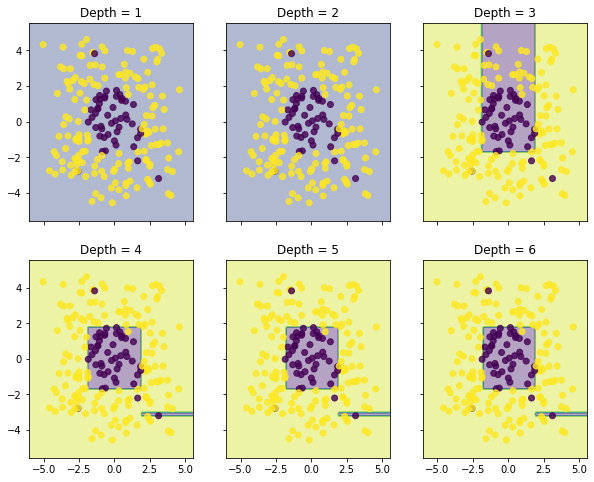

In [8]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [9]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)

#export_graphviz(clf, out_file='tree_classifier.dot')

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)

[Text(133.92000000000002, 201.90857142857143, 'X[0] <= -1.862\nentropy = 0.795\nsamples = 200\nvalue = [48, 152]'),
 Text(50.220000000000006, 170.84571428571428, 'X[1] <= -2.77\nentropy = 0.129\nsamples = 56\nvalue = [1, 55]'),
 Text(33.480000000000004, 139.78285714285715, 'X[1] <= -2.801\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]'),
 Text(16.740000000000002, 108.72, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(50.220000000000006, 108.72, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(66.96000000000001, 139.78285714285715, 'entropy = 0.0\nsamples = 51\nvalue = [0, 51]'),
 Text(217.62000000000003, 170.84571428571428, 'X[0] <= 1.917\nentropy = 0.911\nsamples = 144\nvalue = [47, 97]'),
 Text(133.92000000000002, 139.78285714285715, 'X[1] <= -1.688\nentropy = 0.998\nsamples = 97\nvalue = [46, 51]'),
 Text(83.70000000000002, 108.72, 'X[0] <= 1.626\nentropy = 0.229\nsamples = 27\nvalue = [1, 26]'),
 Text(66.96000000000001, 77.65714285714284, 'entropy = 0.0\nsamples = 25\nvalu

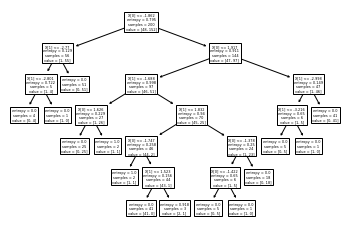

In [10]:
from sklearn import tree

tree.plot_tree(clf)

In [11]:
# Visualize decision tree
#!dot -Tpng tree_classifier.dot -o tree_classifier.png

In [12]:
#Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [13]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calculate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
    
    n = len(y)
    
    mae = (1/n)*np.abs(np.sum(y-np.median(y)))
    
    return mae

In [14]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

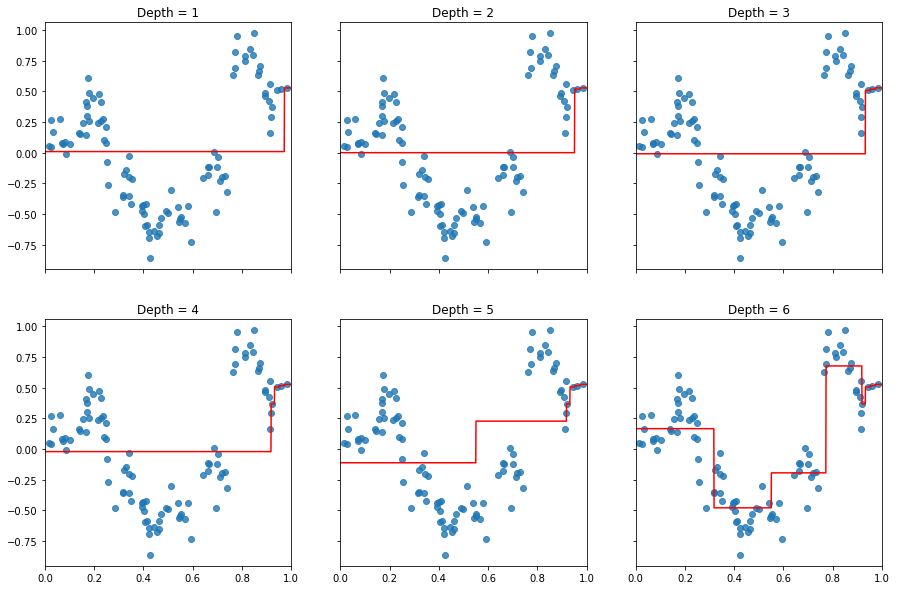

In [15]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Gradient Boosting Method

In [16]:
#Pseudo-residual function.
#Here you can assume that we are using L2 loss

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target-train_predict

In [17]:
from sklearn.tree import DecisionTreeRegressor

In [18]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        # Your code goes here
        
        models_list = []
        pseudo_res = train_target.copy()
        tree = DecisionTreeRegressor(criterion='mse', max_depth=self.max_depth, min_samples_split=self.min_sample)
        model = tree.fit(train_data, train_target)
        models_list.append(model)
        
        for m in range(self.n_estimator): 
            pseudo_res = pseudo_residual_L2(train_target, model.predict(train_data).reshape(-1,1))
            tree = DecisionTreeRegressor(criterion='mse', max_depth=self.max_depth, min_samples_split=self.min_sample)
            model = tree.fit(train_data, pseudo_res)
            models_list.append(model)
            
        
        self.models_list = models_list
        return self, models_list
    
    def predict(self, test_data):
        '''
        Predict value
        '''
        # Your code goes here
        pred = self.models_list[0].predict(test_data)
        
        for model in self.models_list[1:]:
            pred += (self.learning_rate)*(model.predict(test_data))
        return pred
        

# 2-D GBM visualization - SVM data

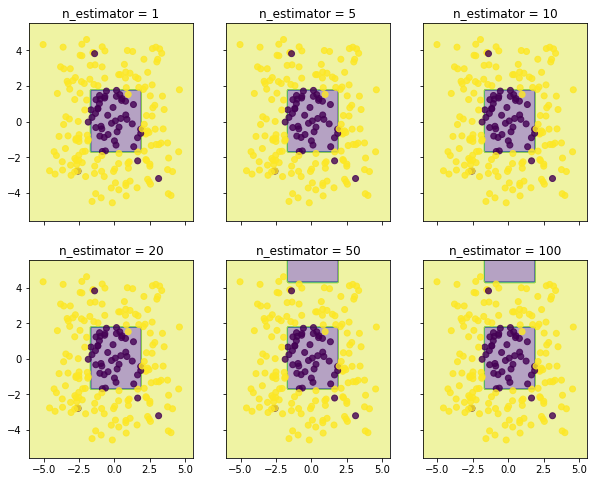

In [19]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbt.fit(x_train, y_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

# 1-D GBM visualization - KRR data

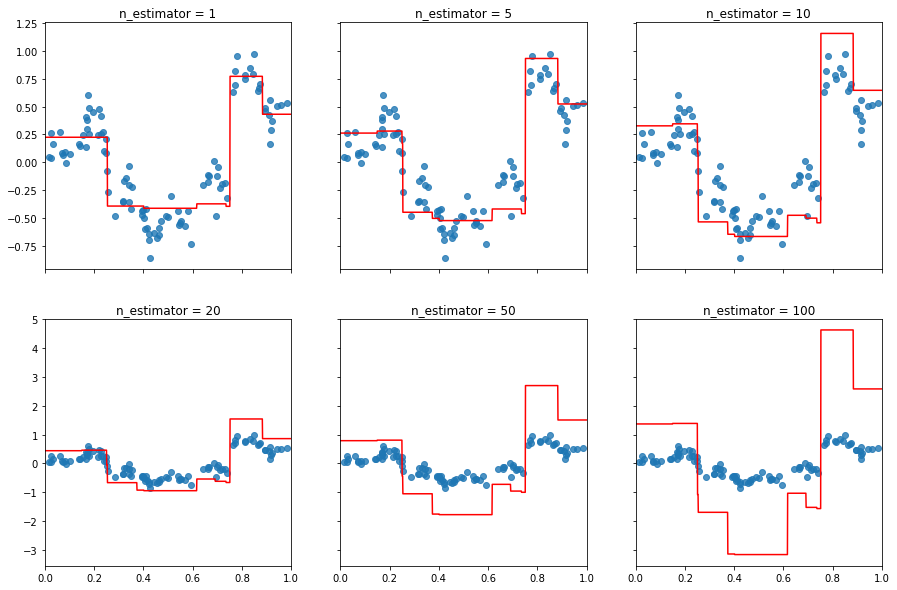

In [20]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)